In [14]:
from rich import print as rprint
import pandas as pd

from src.dataloaders import OverrulingDataset, HeadlineDataset, CoQADataset, GSM8KDataset
from src.methods import AutoMix, EnsembleCascade, FrugalGPT, MOTLLMCascade

from src.api_service import TogetherAIAPI, OpenAIAPI

In [15]:
import os
os.environ['TOGETHER_API_KEY'] = '5de421f4d56d44ac7400e98c3cac5dc98e184bc92e297e552aadd7198def0661'

In [42]:
ensemble_cascade_2level = [
    [
        'meta-llama/Llama-3.2-3B-Instruct-Turbo',
        'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
        # 'google/gemma-2-9b-it',
        'mistralai/Mistral-7B-Instruct-v0.3',
    ],
    'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
]

ensemble_cascade_3level = [
    [
        'meta-llama/Llama-3.2-3B-Instruct-Turbo',
        'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
        # 'google/gemma-2-9b-it',
        'mistralai/Mistral-7B-Instruct-v0.3',
    ],
    [
        'Qwen/Qwen2-72B-Instruct',
        'microsoft/WizardLM-2-8x22B',
        'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
        # 'deepseek-ai/deepseek-llm-67b-chat', # can swap for `lite` if we want to reduce cost further
    ],
    'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo',
]
single_models = [x for i in ensemble_cascade_3level for x in ([i] if isinstance(i, str) else i)]


In [43]:
single_models_cascade_2level = [
    'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
    'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
]

single_models_cascade_3level = [
    'meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo',
    'meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo',
    'meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo',
]

## GSM8K Task

In [44]:
Task1 = GSM8KDataset()
API1 = TogetherAIAPI(TaskData=Task1)


### Single Models Run

In [45]:
results = []

In [46]:
for model in single_models:
    print(f"Running inference on {model}...")
    single_run = EnsembleCascade( 
        # ensemble cascade works well for just a single model, if only one model is passed in
        API1, Task1, [model],
    )
    accurracy, avg_latency, total_cost = single_run.inference_cascade()
    print(accurracy, avg_latency, total_cost)
    results.append({
        "model": model.split('/')[-1],
        "accuracy": accurracy,
        "cost": total_cost,
        "avg_latency": avg_latency,
    })

Running inference on meta-llama/Llama-3.2-3B-Instruct-Turbo...
Starting inference engine...
Calculating accuracy with offline labels...
0.8 2.5806227684020997 0.00023946
Running inference on meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo...
Starting inference engine...
Calculating accuracy with offline labels...
0.8 3.670637607574463 0.0006784199999999999
Running inference on mistralai/Mistral-7B-Instruct-v0.3...
Starting inference engine...
Calculating accuracy with offline labels...
0.4 2.990202760696411 0.0009038000000000001
Running inference on Qwen/Qwen2-72B-Instruct...
Starting inference engine...
Calculating accuracy with offline labels...
0.8 7.4482344627380375 0.0037935
Running inference on microsoft/WizardLM-2-8x22B...
Starting inference engine...
Calculating accuracy with offline labels...
0.8 3.0688474655151365 0.0009324
Running inference on meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo...
Starting inference engine...
Calculating accuracy with offline labels...
0.8 6.5171587467

### Two-level Cascade

In [47]:
c_results = {}

c_results['MoT-LLM Cascade 2-level'] = MOTLLMCascade(
    ServiceProvider=API1,
    TaskData=Task1,
    cascade_tier_models=single_models_cascade_2level,
).inference_cascade()

c_results['CoE 2-level'] = EnsembleCascade(
    ServiceProvider=API1,
    TaskData=Task1,
    cascade_tier_models=ensemble_cascade_2level
).inference_cascade()

c_results['AutoMix_T 2-level'] = AutoMix(API1, Task1, 
    single_models_cascade_2level,
    routing_strategy="threshold", # or "pomdp",
    train=True
).inference_cascade()

c_results['AutoMix_P 2-level'] = AutoMix(API1, Task1, 
    single_models_cascade_2level,
    routing_strategy="pomdp", # or "pomdp",
    train=True
).inference_cascade()

c_results['FrugalGPT 2-level'] = FrugalGPT(
    API1, Task1, single_models_cascade_2level, train=True
).inference_cascade()

Starting inference engine...
Pattern match error!
Pattern match error!
Calculating accuracy with offline labels...
Starting inference engine...
Calculating accuracy with offline labels...
Training AutoMix's routing function...
Training the routing function for meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo and meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo...
Training samples for router set to  75
Generating inference on data subset for training...
Pattern match error!
Pattern match error!
Pattern match error!
Pattern match error!
Pattern match error!
Done with initial inference generation. Starting router training...!
Training complete!
Routing tools:  {0: {'FOLDER': 'automix_router_logs/gsm8k/', 'best_param': np.float64(1.0)}}
Starting inference engine...

Setup cost in $$: 0.0830977
Setup latency: 754.1606161594391
Calculating accuracy with offline labels...
Training AutoMix's routing function...
Training the routing function for meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo and meta-llama

In [ ]:
c_results['MoT-LLM Cascade 3-level'] = MOTLLMCascade(
    ServiceProvider=API1,
    TaskData=Task1,
    cascade_tier_models=single_models_cascade_3level,
).inference_cascade()

c_results['CoE 3-level'] = EnsembleCascade(
    ServiceProvider=API1,
    TaskData=Task1,
    cascade_tier_models=ensemble_cascade_3level
).inference_cascade()

c_results['AutoMix_T 3-level'] = AutoMix(API1, Task1, 
    single_models_cascade_3level,
    routing_strategy="threshold", # or "pomdp",
    train=True
).inference_cascade()

c_results['AutoMix_P 3-level'] = AutoMix(API1, Task1, 
    single_models_cascade_3level,
    routing_strategy="pomdp", # or "pomdp",
    train=True
).inference_cascade()

c_results['FrugalGPT 3-level'] = FrugalGPT(
    API1, Task1, single_models_cascade_3level, train=True
).inference_cascade()

for k, v in c_results.items():
    results.append({
    "model": k,
    "accuracy": v[0],
    "cost": v[2],
    "avg_latency": v[1],
})

In [48]:
df_results = pd.DataFrame(results) 

df_results.to_csv("single_models_gsm8k.csv", index=False)
df_results

,model,accuracy,cost,avg_latency
0,Llama-3.2-3B-Instruct-Turbo,0.8,0.000239,2.580623
1,Meta-Llama-3.1-8B-Instruct-Turbo,0.8,0.000678,3.670638
2,Mistral-7B-Instruct-v0.3,0.4,0.000904,2.990203
3,Qwen2-72B-Instruct,0.8,0.003793,7.448234
4,WizardLM-2-8x22B,0.8,0.000932,3.068847
5,Meta-Llama-3.1-70B-Instruct-Turbo,0.8,0.003332,6.517159
6,Meta-Llama-3.1-405B-Instruct-Turbo,1.0,0.018775,3.726282
7,MoT-LLM Cascade 2-level,1.0,0.006311,23.474042
8,CoE 2-level,1.0,0.001469,20.085112
9,AutoMix_T 2-level,0.8,0.006813,17.390454


### Three-level Cascade

It is quite interesting! A 3-level cascade can achieve a perfect accuracy score, comparable with the best model (Llama-3.1-405) performance; 0.02285:0.183515 = 0.12 (almost 10 times cheaper)

## OVERRULING TASK

In [15]:
Task2 = OverrulingDataset()
API2 = TogetherAIAPI(TaskData=Task2)

In [28]:
results = []

for model in single_models:
    print(f"Running inference on {model}...")
    single_run = EnsembleCascade( 
        # ensemble cascade works well for just a single model, if only one model is passed in
        API2, Task2, [model],
    )
    accurracy, avg_latency, total_cost = single_run.inference_cascade(len_data=50)
    print(accurracy, avg_latency, total_cost)
    results.append({
        "model": model.split('/')[-1],
        "accuracy": accurracy,
        "cost": total_cost,
        "avg_latency": avg_latency,
    })

Running inference on meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo...
Starting inference engine...
Calculating accuracy with offline labels...
0.88 1.0728195667266847 0.006127559999999999
Running inference on meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo...
Starting inference engine...
Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Calculating accuracy with offline labels...
0.92 0.6382067012786865 0.02115608
Running inference on meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo...
Starting inference engine...
Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Calculating accuracy with offline labels...
0.96 0.6322822952270508 0.12023500000000004
Running inference on meta-llama/Meta-Llama-3-8B-Instruct-Turbo...
Starting inference engine...
Calculating accuracy with offline labels...
0.92 1.0372341966629028 0.006169319999999999
Runni

In [ ]:
c_results = {}

c_results['MoT-LLM Cascade 2-level'] = MOTLLMCascade(
    ServiceProvider=API2,
    TaskData=Task2,
    cascade_tier_models=single_models_cascade_2level,
).inference_cascade()

c_results['CoE 2-level'] = EnsembleCascade(
    ServiceProvider=API2,
    TaskData=Task2,
    cascade_tier_models=ensemble_cascade_2level
).inference_cascade()

c_results['AutoMix_T 2-level'] = AutoMix(API2, Task2, 
    single_models_cascade_2level,
    routing_strategy="threshold", # or "pomdp",
    train=True
).inference_cascade()

c_results['AutoMix_P 2-level'] = AutoMix(API2, Task2, 
    single_models_cascade_2level,
    routing_strategy="pomdp", # or "pomdp",
    train=True
).inference_cascade()

c_results['FrugalGPT 2-level'] = FrugalGPT(
    API2, Task2, single_models_cascade_2level, train=True
).inference_cascade()

In [ ]:
c_results['MoT-LLM Cascade 3-level'] = MOTLLMCascade(
    ServiceProvider=API2,
    TaskData=Task2,
    cascade_tier_models=single_models_cascade_3level,
).inference_cascade()

c_results['CoE 3-level'] = EnsembleCascade(
    ServiceProvider=API2,
    TaskData=Task2,
    cascade_tier_models=ensemble_cascade_3level
).inference_cascade()

c_results['AutoMix_T 3-level'] = AutoMix(API2, Task2, 
    single_models_cascade_3level,
    routing_strategy="threshold", # or "pomdp",
    train=True
).inference_cascade()

c_results['AutoMix_P 3-level'] = AutoMix(API2, Task2, 
    single_models_cascade_3level,
    routing_strategy="pomdp", # or "pomdp",
    train=True
).inference_cascade()

c_results['FrugalGPT 3-level'] = FrugalGPT(
    API2, Task2, single_models_cascade_3level, train=True
).inference_cascade()

for k, v in c_results.items():
    results.append({
    "model": k,
    "accuracy": v[0],
    "cost": v[2],
    "avg_latency": v[1],
})

In [29]:
df_results = pd.DataFrame(results) 

df_results.to_csv("single_models_overruling.csv", index=False)
df_results

,model,accuracy,cost,avg_latency
0,Meta-Llama-3.1-8B-Instruct-Turbo,0.88,0.006128,1.072820
1,Meta-Llama-3.1-70B-Instruct-Turbo,0.92,0.021156,0.638207
2,Meta-Llama-3.1-405B-Instruct-Turbo,0.96,0.120235,0.632282
3,Meta-Llama-3-8B-Instruct-Turbo,0.92,0.006169,1.037234
4,Meta-Llama-3-70B-Instruct-Turbo,0.96,0.022703,1.036012
5,Meta-Llama-3-8B-Instruct-Lite,0.82,0.003609,2.512981
6,Meta-Llama-3-70B-Instruct-Lite,0.94,0.015199,4.673916
7,Llama-3-8b-chat-hf,0.82,0.006084,0.751862
8,Llama-3-70b-chat-hf,0.96,0.022629,0.661931
9,Llama-2-13b-chat-hf,0.60,0.013339,3.438242


## HEADLINE Task

In [7]:
Task3 = HeadlineDataset()
API3 = TogetherAIAPI(TaskData=Task3)

In [38]:
results = []

In [48]:
for model in single_models:
    print(f"Running inference on {model}...")
    single_run = EnsembleCascade( 
        # ensemble cascade works well for just a single model, if only one model is passed in
        API3, Task3, [model],
    )
    accurracy, avg_latency, total_cost = single_run.inference_cascade(len_data=50)
    print(accurracy, avg_latency, total_cost)
    results.append({
        "model": model.split('/')[-1],
        "accuracy": accurracy,
        "cost": total_cost,
        "avg_latency": avg_latency,
    })

Running inference on meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo...
Starting inference engine...
Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Calculating accuracy with offline labels...
0.0 0.5261833333969116 0.003052980000000001
Running inference on meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo...
Starting inference engine...
Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Calculating accuracy with offline labels...
0.0 0.7569611501693726 0.013845040000000003
Running inference on meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo...
Starting inference engine...
Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Calculating accuracy with offline labels...
0.0 0.6313478326797486 0.077735
Running inference on meta-llama/Meta-Llama-3-8B-Instruct-Turbo...
Starting inference engine...
Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern err

In [ ]:
c_results = {}

c_results['MoT-LLM Cascade 2-level'] = MOTLLMCascade(
    ServiceProvider=API3,
    TaskData=Task3,
    cascade_tier_models=single_models_cascade_2level,
).inference_cascade()

c_results['CoE 2-level'] = EnsembleCascade(
    ServiceProvider=API3,
    TaskData=Task3,
    cascade_tier_models=ensemble_cascade_2level
).inference_cascade()

c_results['AutoMix_T 2-level'] = AutoMix(API3, Task3, 
    single_models_cascade_2level,
    routing_strategy="threshold", # or "pomdp",
    train=True
).inference_cascade()

c_results['AutoMix_P 2-level'] = AutoMix(API3, Task3, 
    single_models_cascade_2level,
    routing_strategy="pomdp", # or "pomdp",
    train=True
).inference_cascade()

c_results['FrugalGPT 2-level'] = FrugalGPT(
    API3, Task3, single_models_cascade_2level, train=True
).inference_cascade()

In [ ]:
c_results['MoT-LLM Cascade 3-level'] = MOTLLMCascade(
    ServiceProvider=API3,
    TaskData=Task3,
    cascade_tier_models=single_models_cascade_3level,
).inference_cascade()

c_results['CoE 3-level'] = EnsembleCascade(
    ServiceProvider=API3,
    TaskData=Task3,
    cascade_tier_models=ensemble_cascade_3level
).inference_cascade()

c_results['AutoMix_T 3-level'] = AutoMix(API3, Task3, 
    single_models_cascade_3level,
    routing_strategy="threshold", # or "pomdp",
    train=True
).inference_cascade()

c_results['AutoMix_P 3-level'] = AutoMix(API3, Task3, 
    single_models_cascade_3level,
    routing_strategy="pomdp", # or "pomdp",
    train=True
).inference_cascade()

c_results['FrugalGPT 3-level'] = FrugalGPT(
    API3, Task3, single_models_cascade_3level, train=True
).inference_cascade()

for k, v in c_results.items():
    results.append({
    "model": k,
    "accuracy": v[0],
    "cost": v[2],
    "avg_latency": v[1],
})

In [49]:
df_results = pd.DataFrame(results)

df_results.to_csv("single_models_headlines.csv", index=False)
df_results

,model,accuracy,cost,avg_latency
0,Meta-Llama-3.1-8B-Instruct-Turbo,0.06,0.009597,0.639124
1,Meta-Llama-3.1-70B-Instruct-Turbo,0.44,0.043754,0.704108
2,Meta-Llama-3.1-405B-Instruct-Turbo,0.40,0.248970,0.950428
3,Meta-Llama-3-8B-Instruct-Turbo,0.32,0.008774,0.438596
4,Meta-Llama-3-70B-Instruct-Turbo,0.52,0.042872,0.705439
5,Meta-Llama-3-8B-Instruct-Lite,0.30,0.004892,0.460506
6,Meta-Llama-3-70B-Instruct-Lite,0.48,0.026315,1.598934
7,Llama-3-8b-chat-hf,0.24,0.009744,0.590593
8,Llama-3-70b-chat-hf,0.56,0.043804,0.466037
9,Llama-2-13b-chat-hf,0.16,0.017438,1.336370


## CoQA Task

In [7]:
Task4 = CoQADataset()
API4 = TogetherAIAPI(TaskData=Task4)

In [8]:
results = []

In [42]:
for model in single_models:
    print(f"Running inference on {model}...")
    single_run = EnsembleCascade( 
        # ensemble cascade works well for just a single model, if only one model is passed in
        API4, Task4, [model],
    )
    accurracy, avg_latency, total_cost = single_run.inference_cascade(len_data=50)
    print(accurracy, avg_latency, total_cost)
    results.append({
        "model": model.split('/')[-1],
        "accuracy": accurracy,
        "cost": total_cost,
        "avg_latency": avg_latency,
    })

Running inference on meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo...
Starting inference engine...
Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the old-fashioned way...
Answer not found in ==> `{r}`


Pattern error in regex. Using the

In [ ]:
c_results = {}

c_results['MoT-LLM Cascade 2-level'] = MOTLLMCascade(
    ServiceProvider=API4,
    TaskData=Task4,
    cascade_tier_models=single_models_cascade_2level,
).inference_cascade()

c_results['CoE 2-level'] = EnsembleCascade(
    ServiceProvider=API4,
    TaskData=Task4,
    cascade_tier_models=ensemble_cascade_2level
).inference_cascade()

c_results['AutoMix_T 2-level'] = AutoMix(API4, Task4, 
    single_models_cascade_2level,
    routing_strategy="threshold", # or "pomdp",
    train=True
).inference_cascade()

c_results['AutoMix_P 2-level'] = AutoMix(API4, Task4, 
    single_models_cascade_2level,
    routing_strategy="pomdp", # or "pomdp",
    train=True
).inference_cascade()

c_results['FrugalGPT 2-level'] = FrugalGPT(
    API4, Task4, single_models_cascade_2level, train=True
).inference_cascade()

In [ ]:
c_results['MoT-LLM Cascade 3-level'] = MOTLLMCascade(
    ServiceProvider=API4,
    TaskData=Task4,
    cascade_tier_models=single_models_cascade_3level,
).inference_cascade()

c_results['CoE 3-level'] = EnsembleCascade(
    ServiceProvider=API4,
    TaskData=Task4,
    cascade_tier_models=ensemble_cascade_3level
).inference_cascade()

c_results['AutoMix_T 3-level'] = AutoMix(API4, Task4, 
    single_models_cascade_3level,
    routing_strategy="threshold", # or "pomdp",
    train=True
).inference_cascade()

c_results['AutoMix_P 3-level'] = AutoMix(API4, Task4, 
    single_models_cascade_3level,
    routing_strategy="pomdp", # or "pomdp",
    train=True
).inference_cascade()

c_results['FrugalGPT 3-level'] = FrugalGPT(
    API4, Task4, single_models_cascade_3level, train=True
).inference_cascade()

for k, v in c_results.items():
    results.append({
    "model": k,
    "accuracy": v[0],
    "cost": v[2],
    "avg_latency": v[1],
})

In [43]:
df_results = pd.DataFrame(results)

df_results.to_csv("single_models_coqa.csv", index=False)
df_results

,model,accuracy,cost,avg_latency
0,Meta-Llama-3.1-8B-Instruct-Turbo,0.06,0.009597,0.639124
1,Meta-Llama-3.1-70B-Instruct-Turbo,0.44,0.043754,0.704108
2,Meta-Llama-3.1-405B-Instruct-Turbo,0.40,0.248970,0.950428
3,Meta-Llama-3-8B-Instruct-Turbo,0.32,0.008774,0.438596
4,Meta-Llama-3-70B-Instruct-Turbo,0.52,0.042872,0.705439
5,Meta-Llama-3-8B-Instruct-Lite,0.30,0.004892,0.460506
6,Meta-Llama-3-70B-Instruct-Lite,0.48,0.026315,1.598934
7,Llama-3-8b-chat-hf,0.24,0.009744,0.590593
8,Llama-3-70b-chat-hf,0.56,0.043804,0.466037
9,Llama-2-13b-chat-hf,0.16,0.017438,1.336370


#### Plots

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from adjustText import adjust_text

sns.set_style("whitegrid")

In [30]:
font_ = 15
legendfont_ = 15
matplotlib.rcParams.update({"text.usetex": False, 'font.size': font_})
matplotlib.rcParams.update({"legend.fontsize": legendfont_})
plt.rcParams['font.family'] = 'serif'

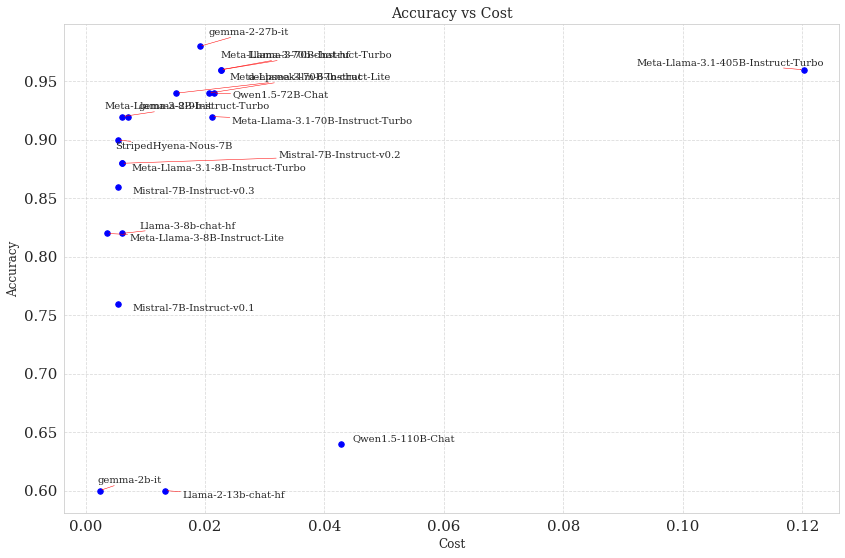

In [31]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_results['cost'], df_results['accuracy'], s=30, color='blue')

texts = []
for i, model in enumerate(df_results['model']):
    texts.append(plt.text(df_results['cost'][i], df_results['accuracy'][i], model, fontsize=10))

plt.title('Accuracy vs Cost', fontsize=14)
plt.xlabel('Cost', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

# Adjust the text labels to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

plt.tight_layout()
plt.show()

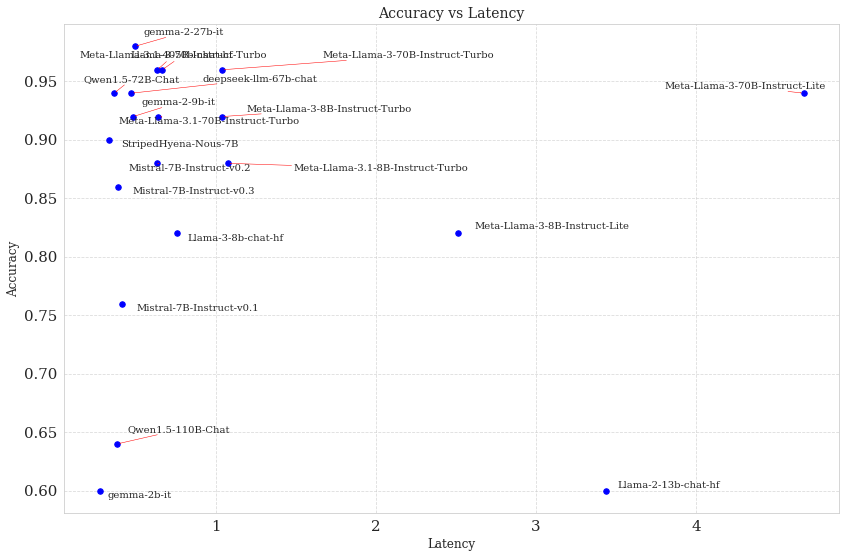

In [32]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_results['avg_latency'], df_results['accuracy'], s=30, color='blue')

texts = []
for i, model in enumerate(df_results['model']):
    texts.append(plt.text(df_results['avg_latency'][i], df_results['accuracy'][i], model, fontsize=10))

plt.title('Accuracy vs Latency', fontsize=14)
plt.xlabel('Latency', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

# Adjust the text labels to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

plt.tight_layout()
plt.show()